In [1]:
## 加载包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
## 图像在jupyter notebook中显示
%matplotlib inline
## 显示的图片格式（mac中的高清格式），还可以设置为"bmp"等格式
%config InlineBackend.figure_format = "retina"
## 输出图显示中文
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "/Library/Fonts/华文细黑.ttf",size=14)
## 引入3D坐标系
from mpl_toolkits.mplot3d import Axes3D
## cm模块提供大量的colormap函数
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns

from sklearn import tree,metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import graphviz
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image  

## 忽略提醒
import warnings
warnings.filterwarnings("ignore")


## 使用决策树分析泰坦尼克号数据

In [2]:
## 读取训练集和测试集
train = pd.read_csv("/Users/daitu/慕课/Python机器学习入门/data/Titanic train.csv")
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
300,301,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,NaN,0,0,9234,7.75,NaN,Q
394,395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.70,G6,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.00,B28,NaN
90,91,0,3,"Christmann, Mr. Emil",male,29.0,0,0,343276,8.05,NaN,S
199,200,0,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.00,NaN,S


Pclass：船票的等级

SibSp： 在泰坦尼克号上的兄弟姐妹或者配偶数量

parch ：在泰坦尼克号上的父母或者孩子数量

Ticket：船票号码

Fare ： 乘客票价

Cabin ： 客舱号码

Embarked ：登上船的港口C =瑟堡，Q =皇后镇，S =南安普敦


In [3]:
test = pd.read_csv("/Users/daitu/慕课/Python机器学习入门/data/Titanic test.csv")
test.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
206,1098,3,"McGowan, Miss. Katherine",female,35.0,0,0,9232,7.7500,NaN,Q
347,1239,3,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C
335,1227,1,"Maguire, Mr. John Edward",male,30.0,0,0,110469,26.0000,C106,S
356,1248,1,"Brown, Mrs. John Murray (Caroline Lane Lamson)",female,59.0,2,0,11769,51.4792,C101,S
331,1223,1,"Dulles, Mr. William Crothers",male,39.0,0,0,PC 17580,29.7000,A18,C


In [4]:
## 将两个数据集组成一个列表
data_pro = [train,test]

###  数据预处理


In [5]:
## 检查缺失值
print("训练集的列缺失值的情况:\n", train.isnull().sum())
print("-"*20)

print("测试集的列缺失值的情况:\n", test.isnull().sum())
print("-"*20)

训练集的列缺失值的情况:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
测试集的列缺失值的情况:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
--------------------


In [6]:
## 填补缺失值
for dataset in data_pro:    
    # 使用随机数填补缺失的
    mean = dataset["Age"].mean()
    std = dataset["Age"].std()
    num = dataset["Age"].isnull().sum()
    # 使用均值和标准差生成相应的随机整数数
    rand_age = np.random.randint(mean - std, mean + std, size = num)
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)

    #使用众数来填补登上船的港口
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    # 使用中位数来填补乘客的票价
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

# 删除具有精确表示能力的数据列，和有大量缺失值的数据Cabin
drop_column = ["PassengerId","Cabin", "Ticket"]
train.drop(drop_column, axis=1, inplace = True)

print(train.isnull().sum())
print("-"*20)
print(test.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [7]:
## 对数据集进行特征工程,增加新的特征
for dataset in data_pro:    
    # 计算家庭人口在船上的数量
    dataset["FamilySize"] = dataset ["SibSp"] + dataset["Parch"] + 1
    ## 添加新的变量，是否独自一人
    dataset["IsAlone"] = 1 
    dataset["IsAlone"].loc[dataset["FamilySize"] > 1] = 0 

    # 提取每个乘客的称谓，例如，先生、女士......
    dataset["Tittle"] = dataset["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    ## 将船费切分为5个离散区间
    dataset["FareBins"] = pd.qcut(dataset["Fare"].astype(int), 5)
    
    # 将年龄切分为6个离散区间
    dataset["AgeBins"] = pd.cut(dataset["Age"].astype(int), 6)


In [8]:
## 查看称呼的数量
print(train['Tittle'].value_counts())
## 查看称呼的数量
print(test['Tittle'].value_counts())

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Mme               1
Capt              1
the Countess      1
Jonkheer          1
Ms                1
Sir               1
Don               1
Lady              1
Name: Tittle, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Ms          1
Dr          1
Name: Tittle, dtype: int64


In [9]:
# 整理称谓,找到数量小于10的称谓，然后使用 Other 代替
for dataset in data_pro:
    tittle_names = (dataset["Tittle"].value_counts() > 10) 
    dataset["Tittle"] = dataset["Tittle"].apply(lambda x: x if tittle_names.loc[x] == True else "Other")

print(train["Tittle"].value_counts())
print("-"*20)
print(test["Tittle"].value_counts())
print("-"*20)

Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: Tittle, dtype: int64
--------------------
Mr        240
Miss       78
Mrs        72
Master     21
Other       7
Name: Tittle, dtype: int64
--------------------


In [10]:
# 查看数据信息
train.info()
test.info()
train.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null int64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Tittle        891 non-null object
FareBins      891 non-null category
AgeBins       891 non-null category
dtypes: category(2), float64(1), int64(7), object(4)
memory usage: 85.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null int64
SibSp          418 non-null int64
Parch          418 non-null int64


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Tittle,FareBins,AgeBins
295,0,1,"Lewy, Mr. Ervin G",male,41,0,0,27.7208,C,1,1,Mr,"(21, 39]","(40, 53.333]"
853,1,1,"Lines, Miss. Mary Conover",female,16,0,1,39.4000,S,2,0,Miss,"(21, 39]","(13.333, 26.667]"
412,1,1,"Minahan, Miss. Daisy E",female,33,1,0,90.0000,Q,2,0,Miss,"(39, 512]","(26.667, 40]"
329,1,1,"Hippach, Miss. Jean Gertrude",female,16,0,1,57.9792,C,2,0,Miss,"(39, 512]","(13.333, 26.667]"
156,1,3,"Gilnagh, Miss. Katherine ""Katie""",female,16,0,0,7.7333,Q,1,1,Miss,"[0, 7]","(13.333, 26.667]"
369,1,1,"Aubart, Mme. Leontine Pauline",female,24,0,0,69.3000,C,1,1,Other,"(39, 512]","(13.333, 26.667]"
680,0,3,"Peters, Miss. Katie",female,40,0,0,8.1375,Q,1,1,Miss,"(7, 10]","(26.667, 40]"
536,0,1,"Butt, Major. Archibald Willingham",male,45,0,0,26.5500,S,1,1,Other,"(21, 39]","(40, 53.333]"
365,0,3,"Adahl, Mr. Mauritz Nils Martin",male,30,0,0,7.2500,S,1,1,Mr,"[0, 7]","(26.667, 40]"
590,0,3,"Rintamaki, Mr. Matti",male,35,0,0,7.1250,S,1,1,Mr,"[0, 7]","(26.667, 40]"


In [11]:
# 将训练集和测试集转化为分类数据

# 编码分类数据
label = LabelEncoder()
for dataset in data_pro:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Tittle_Code'] = label.fit_transform(dataset['Tittle'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBins'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBins'])


In [12]:
# 定于预测目标变量名
Target = ['Survived']

## 定义模型的预测变量名
train_x = ['Pclass','SibSp', 'Parch', 'FamilySize', 'IsAlone','Sex_Code',
           'Embarked_Code', 'Tittle_Code','AgeBin_Code', 'FareBin_Code'] 

#define x variables for original features aka feature selection#pretty name/values for charts

In [13]:
train[train_x].sample(5)

,Pclass,SibSp,Parch,FamilySize,IsAlone,Sex_Code,Embarked_Code,Tittle_Code,AgeBin_Code,FareBin_Code
79,3,0,0,1,1,0,2,1,2,0
86,3,1,3,5,0,1,2,2,1,1
210,3,0,0,1,1,1,2,2,1,4
302,3,0,0,1,1,1,2,2,1,4
890,3,0,0,1,1,1,1,2,2,4


In [14]:
test[train_x].sample(5)

,Pclass,SibSp,Parch,FamilySize,IsAlone,Sex_Code,Embarked_Code,Tittle_Code,AgeBin_Code,FareBin_Code
122,1,1,0,2,0,0,0,3,2,2
25,3,1,0,2,0,1,2,2,3,0
46,1,0,0,1,1,1,0,2,3,1
189,2,0,0,1,1,1,2,2,3,0
43,2,0,0,1,1,0,2,3,2,0


In [15]:
##将训练集切分为训练集和验证集
traindata_x,valdata_x,traindata_y,valdata_y = train_test_split(train[train_x], train[Target],
                                                               test_size = 0.25,random_state = 1)
traindata_x.sample(5)

,Pclass,SibSp,Parch,FamilySize,IsAlone,Sex_Code,Embarked_Code,Tittle_Code,AgeBin_Code,FareBin_Code
336,1,1,0,2,0,1,2,2,2,2
20,2,0,0,1,1,1,2,2,2,1
617,3,1,0,2,0,0,2,3,1,0
741,1,1,0,2,0,1,2,2,2,2
259,2,0,1,2,0,0,2,3,3,1


In [16]:
## 使用决策树
clf = tree.DecisionTreeClassifier(random_state=1)

clf = clf.fit(traindata_x, traindata_y)

In [17]:
## 输出每个特征的重要性
clf.feature_importances_

array([0.15402901, 0.07805268, 0.02420063, 0.05162515, 0.0024709 ,
       0.40237469, 0.03456133, 0.10400837, 0.08815128, 0.06052595])

In [18]:
## 使用模型对验证集进行预测
valpre_y = clf.predict(valdata_x)

In [19]:
## 查看训练集的效果
trainpre_y = clf.predict(traindata_x)
print(metrics.accuracy_score(trainpre_y,trainpre_y))
print(metrics.classification_report(trainpre_y,trainpre_y))

1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       462
          1       1.00      1.00      1.00       206

avg / total       1.00      1.00      1.00       668



In [20]:
## 查看在验证集预测的效果
print(metrics.accuracy_score(valdata_y,valpre_y))
print(metrics.classification_report(valdata_y,valpre_y))

0.7488789237668162
             precision    recall  f1-score   support

          0       0.72      0.91      0.81       128
          1       0.81      0.54      0.65        95

avg / total       0.76      0.75      0.74       223



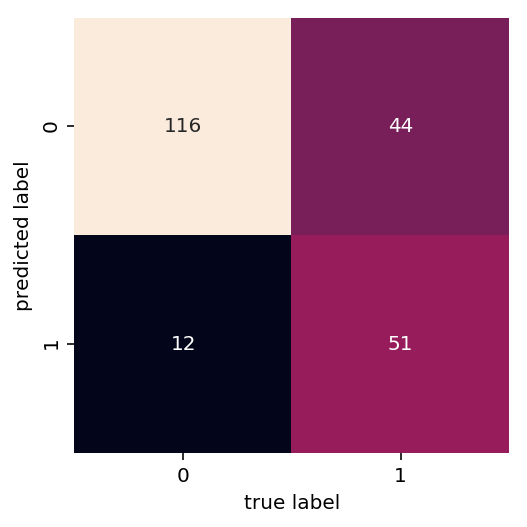

In [21]:
## 输出混淆矩阵
confm = metrics.confusion_matrix(valdata_y,valpre_y)
sns.heatmap(confm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

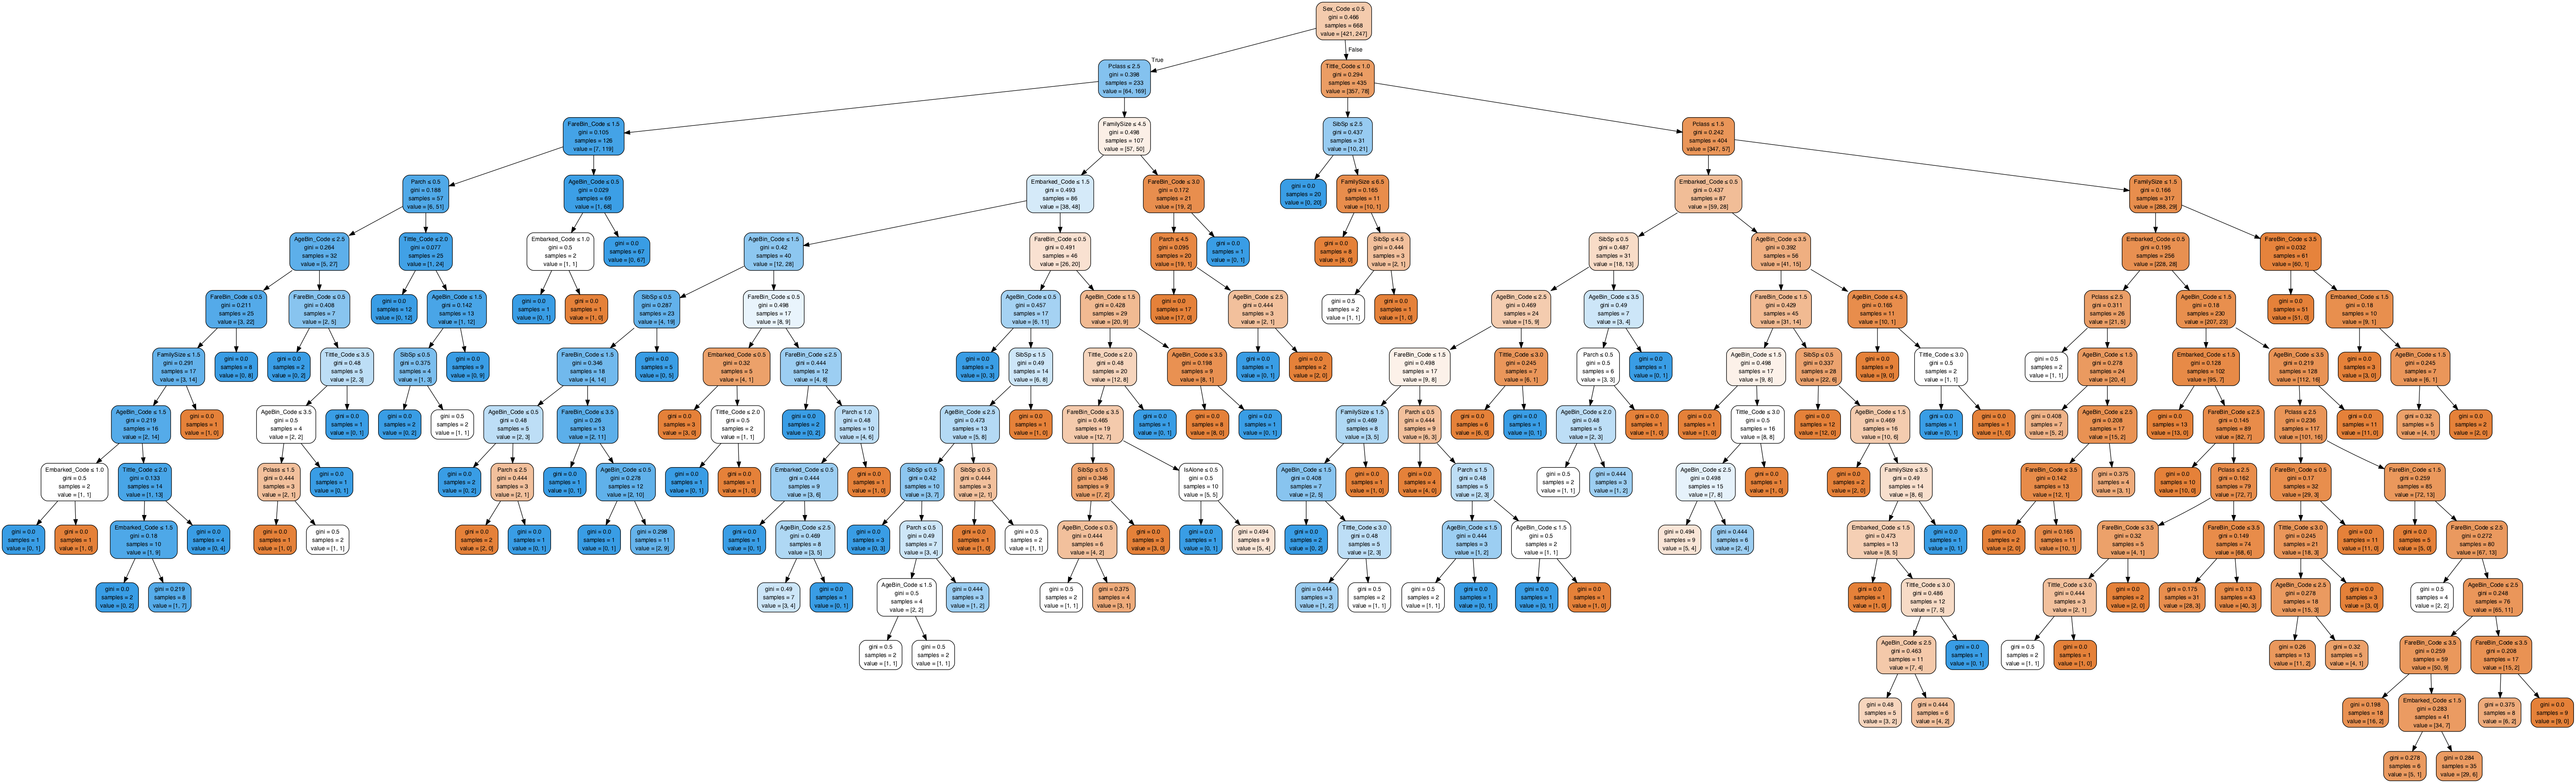

In [22]:
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,
                     feature_names=traindata_x.columns,
                     filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

### 决策树剪枝防止过拟合


In [23]:
## 使用决策树
clf2 = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=20, min_samples_leaf=5,min_samples_split=2,
            random_state=1)

clf2 = clf2.fit(traindata_x, traindata_y)

In [24]:
## 输出每个特征的重要性
clf2.feature_importances_

array([0.1909171 , 0.06904279, 0.        , 0.04462751, 0.00484098,
       0.51416358, 0.02231176, 0.09413418, 0.02659247, 0.03336963])

In [25]:
## 计算在训练集上的表现
trainpre_y2 = clf2.predict(traindata_x)
print(metrics.accuracy_score(trainpre_y,trainpre_y2))
print(metrics.classification_report(trainpre_y,trainpre_y2))

0.9326347305389222
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       462
          1       0.89      0.89      0.89       206

avg / total       0.93      0.93      0.93       668



In [26]:
## 计算在验证集上的表现
valpre_y2 = clf2.predict(valdata_x)
print(metrics.accuracy_score(valdata_y,valpre_y2))
print(metrics.classification_report(valdata_y,valpre_y2))

0.8026905829596412
             precision    recall  f1-score   support

          0       0.77      0.94      0.85       128
          1       0.88      0.62      0.73        95

avg / total       0.82      0.80      0.80       223



**预测的效果比初始的模型更好**

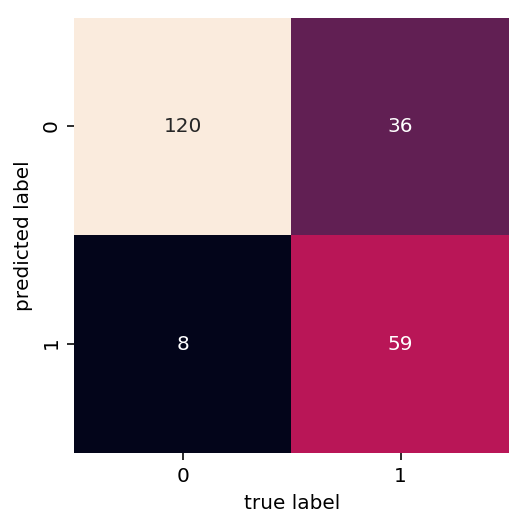

In [27]:
## 输出混淆矩阵
confm = metrics.confusion_matrix(valdata_y,valpre_y2)
sns.heatmap(confm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

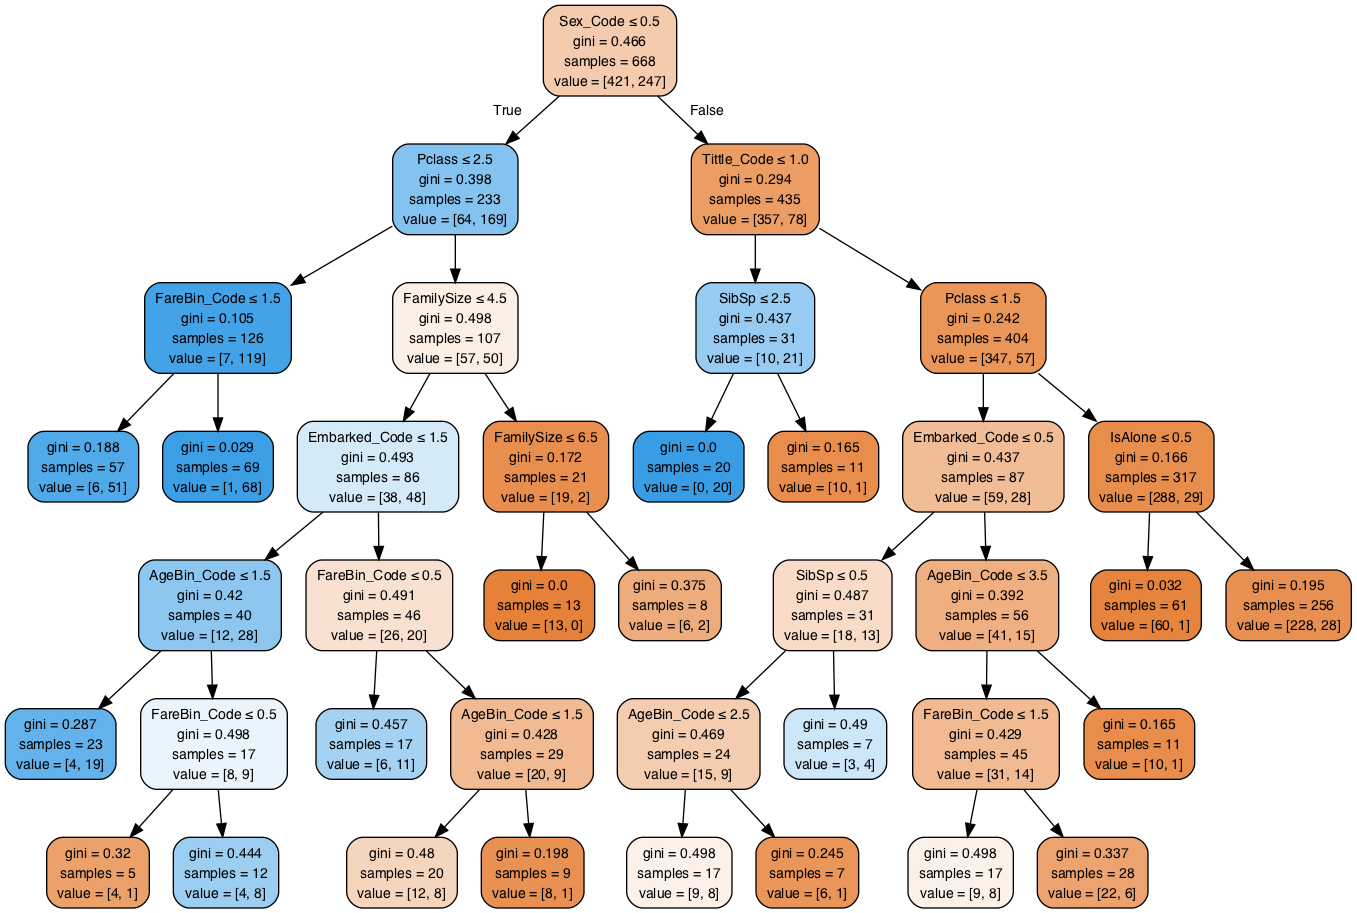

In [28]:
## 可视化新的决策树
dot_data2 = StringIO()
tree.export_graphviz(clf2, out_file=dot_data2,
                     feature_names=traindata_x.columns,
                     filled=True, rounded=True,special_characters=True)
graph2 = pydotplus.graph_from_dot_data(dot_data2.getvalue())  

Image(graph2.create_png(),width=10, height=6, retina=True)

## 随机森林算法

In [29]:
rf = RandomForestClassifier(n_estimators = 500, 
            max_depth=5, oob_score=True, random_state=1)
rf.fit(traindata_x,traindata_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [30]:
print("oob score:", round(rf.oob_score_, 4)*100, "%")

oob score: 83.53 %


In [31]:
## 计算在训练集上的表现
trainpre_y3 = rf.predict(traindata_x)
print(metrics.accuracy_score(trainpre_y,trainpre_y3))
print(metrics.classification_report(trainpre_y,trainpre_y3))

0.9296407185628742
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       462
          1       0.89      0.88      0.89       206

avg / total       0.93      0.93      0.93       668



In [32]:
## 计算在验证集上的表现
valpre_y3 = rf.predict(valdata_x)
print(metrics.accuracy_score(valdata_y,valpre_y3))
print(metrics.classification_report(valdata_y,valpre_y3))

0.7982062780269058
             precision    recall  f1-score   support

          0       0.77      0.93      0.84       128
          1       0.87      0.62      0.72        95

avg / total       0.81      0.80      0.79       223



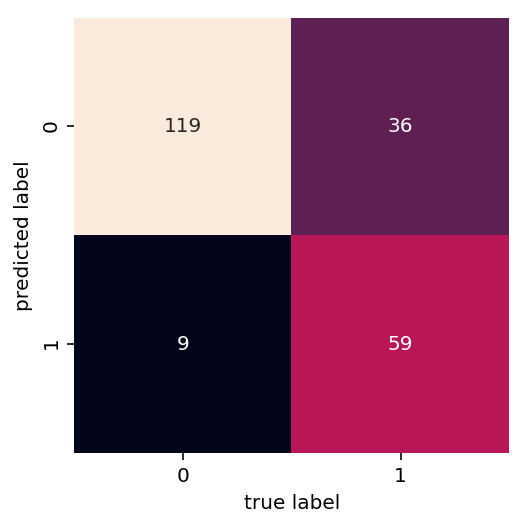

In [33]:
## 输出混淆矩阵
confm = metrics.confusion_matrix(valdata_y,valpre_y3)
sns.heatmap(confm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [34]:
## 查看变量的重要情况
print("变量的重要情况:\n",rf.feature_importances_)

变量的重要情况:
 [0.13657508 0.04140238 0.02146382 0.0773005  0.0154777  0.33640414
 0.03272574 0.21273191 0.05504296 0.07087577]


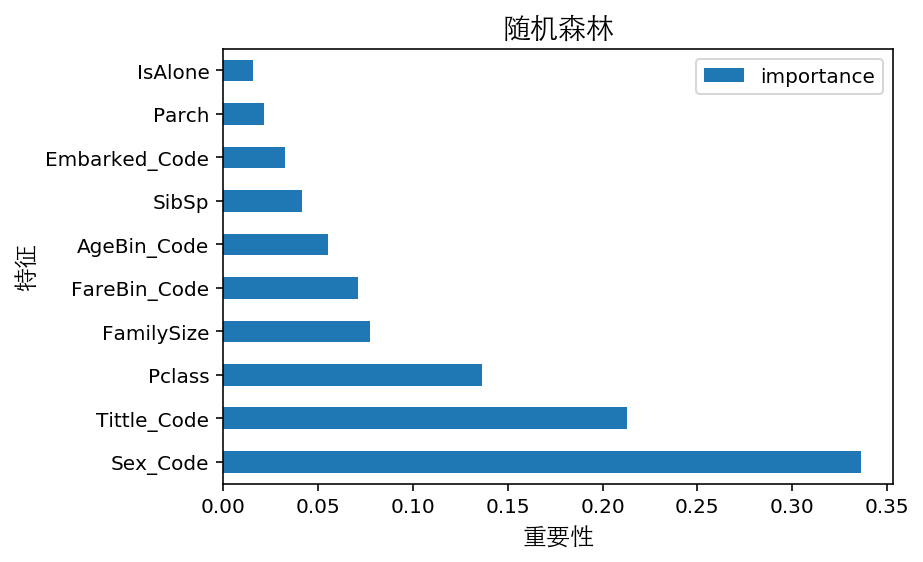

In [35]:
importances = pd.DataFrame({"feature":traindata_x.columns,"importance":rf.feature_importances_})
importances = importances.sort_values("importance",ascending = False)
importances.plot(kind="barh",figsize=(6,4),x = "feature",y = "importance")
plt.ylabel("特征",fontproperties = fonts,size = 12)
plt.xlabel("重要性",fontproperties = fonts,size = 12)
plt.title("随机森林",fontproperties = fonts)
plt.show()

### 对预测集进行预测


In [36]:
## 使用全部训练数据重新训练随机森林
rf= RandomForestClassifier(n_estimators = 500, 
            max_depth=5, oob_score=True, random_state=1)
rf.fit(train[train_x],train[Target])
print("oob score:", round(rf.oob_score_, 4)*100, "%")

oob score: 83.5 %


In [37]:
## 对测试集进行预测
test_y = rf.predict(test[train_x])
test_y

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [38]:
## 使用网格搜索，找到更合适的参数
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
## 定义模型流程
rfgs = RandomForestClassifier(oob_score=True, random_state=1)
## 定义需要搜索的参数
n_estimators = [200,500,1000,2000]
max_depth = [3,5,8,10,15]
para_grid = [{"n_estimators":n_estimators,
              "max_depth" : max_depth}]

## 应用到数据上
gs_rf = GridSearchCV(estimator=rfgs,param_grid=para_grid,
                         cv=5,n_jobs=4)
gs_rf.fit(traindata_x,traindata_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'n_estimators': [200, 500, 1000, 2000], 'max_depth': [3, 5, 8, 10, 15]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
gs_rf.best_params_

{'max_depth': 5, 'n_estimators': 500}

In [40]:
gs_rf.grid_scores_

[mean: 0.82036, std: 0.03695, params: {'max_depth': 3, 'n_estimators': 200},
 mean: 0.82635, std: 0.04313, params: {'max_depth': 3, 'n_estimators': 500},
 mean: 0.82784, std: 0.04045, params: {'max_depth': 3, 'n_estimators': 1000},
 mean: 0.82784, std: 0.04045, params: {'max_depth': 3, 'n_estimators': 2000},
 mean: 0.82485, std: 0.04162, params: {'max_depth': 5, 'n_estimators': 200},
 mean: 0.83533, std: 0.04432, params: {'max_depth': 5, 'n_estimators': 500},
 mean: 0.83383, std: 0.04214, params: {'max_depth': 5, 'n_estimators': 1000},
 mean: 0.83533, std: 0.04333, params: {'max_depth': 5, 'n_estimators': 2000},
 mean: 0.81886, std: 0.03933, params: {'max_depth': 8, 'n_estimators': 200},
 mean: 0.81737, std: 0.04176, params: {'max_depth': 8, 'n_estimators': 500},
 mean: 0.81886, std: 0.04091, params: {'max_depth': 8, 'n_estimators': 1000},
 mean: 0.81587, std: 0.04222, params: {'max_depth': 8, 'n_estimators': 2000},
 mean: 0.80090, std: 0.04165, params: {'max_depth': 10, 'n_estimators'

### 提升树模型 boosting tree 

In [109]:
from sklearn.ensemble import AdaBoostClassifier
## AdaBoostClassifier 分类器，单个模型为决策树模型

In [110]:
abf = AdaBoostClassifier(n_estimators= 50, ## 学习器的最大估计量
                         learning_rate= 1, ## 学习速率
                         random_state=1234)
abf.fit(train[train_x],train[Target])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=50, random_state=1234)

In [111]:
## 计算在训练集上的表现
trainpre_y4 = rf.predict(traindata_x)
print(metrics.accuracy_score(trainpre_y,trainpre_y4))
print(metrics.classification_report(trainpre_y,trainpre_y4))

0.907185628742515
             precision    recall  f1-score   support

          0       0.95      0.92      0.93       462
          1       0.83      0.88      0.85       206

avg / total       0.91      0.91      0.91       668



In [112]:
## 计算在验证集上的表现
valpre_y4 = rf.predict(valdata_x)
print(metrics.accuracy_score(valdata_y,valpre_y4))
print(metrics.classification_report(valdata_y,valpre_y4))

0.8340807174887892
             precision    recall  f1-score   support

          0       0.81      0.94      0.87       128
          1       0.89      0.69      0.78        95

avg / total       0.84      0.83      0.83       223



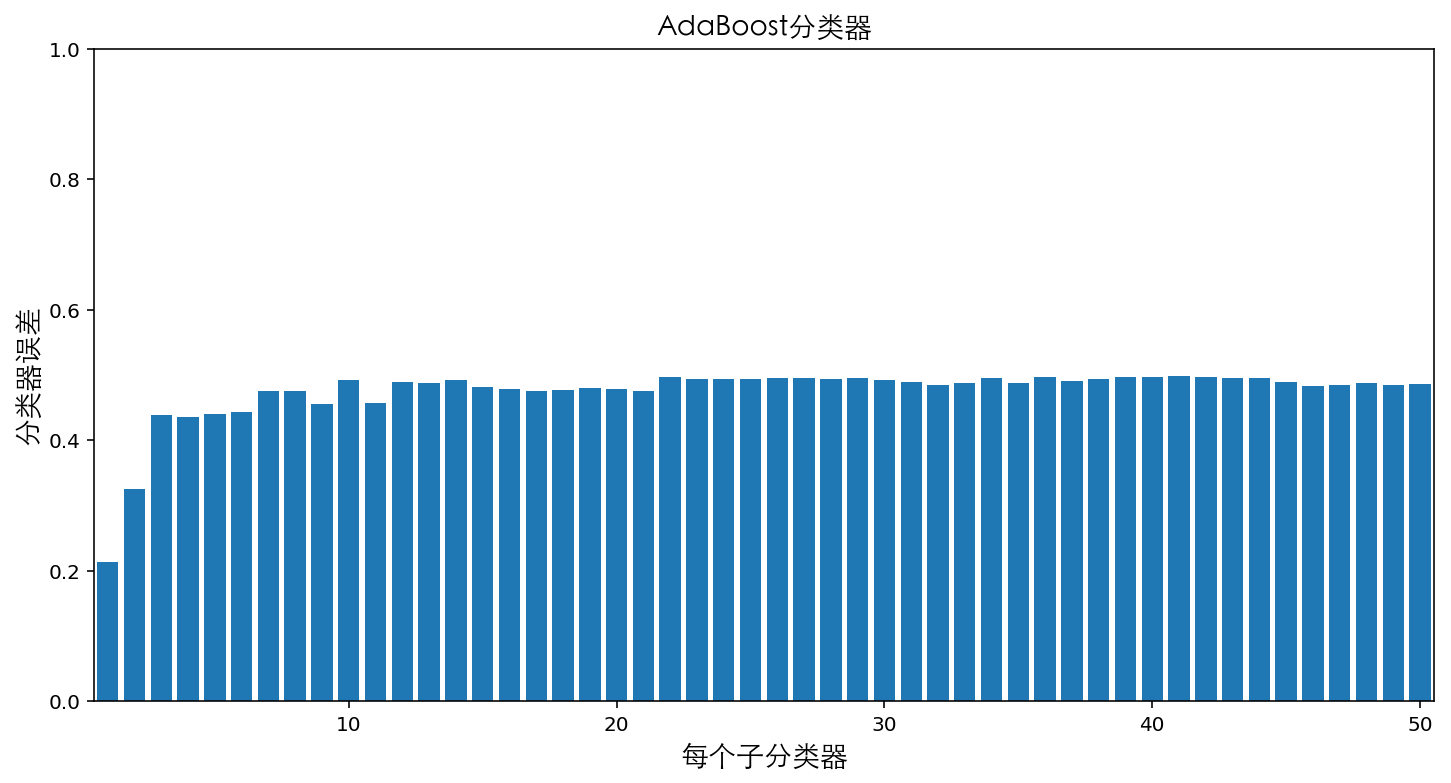

In [113]:
## 输出每个决策树估计期的错误率
abf.estimator_errors_
plt.figure(figsize=(12,6))
plt.bar(np.arange(len(abf.estimator_errors_))+1,abf.estimator_errors_)
plt.ylim([0,1])
plt.xlim([0.5,50.5])
plt.xlabel("每个子分类器",FontProperties = fonts)
plt.ylabel("分类器误差",FontProperties = fonts)
plt.title("AdaBoost分类器",FontProperties = fonts)
plt.show()

可以发现大部分单个子模型的误差都大于0.4，但是这么多弱分类器组合起来，得到的分类精度却远远高于50%，在测试集上能够达到83%的准确率。

In [114]:
## 每个估计器，即每个决策树的情况
abf.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=822569775, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=2137449171, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_le

In [115]:
from sklearn import clone
## 用相同的参数构造一个新的估计器。
## Clone在估计器中完成模型的深层副本，而不实际复制附加数据。 它产生了一个具有相同参数的新估计器，该参数尚未适用于任何数据。

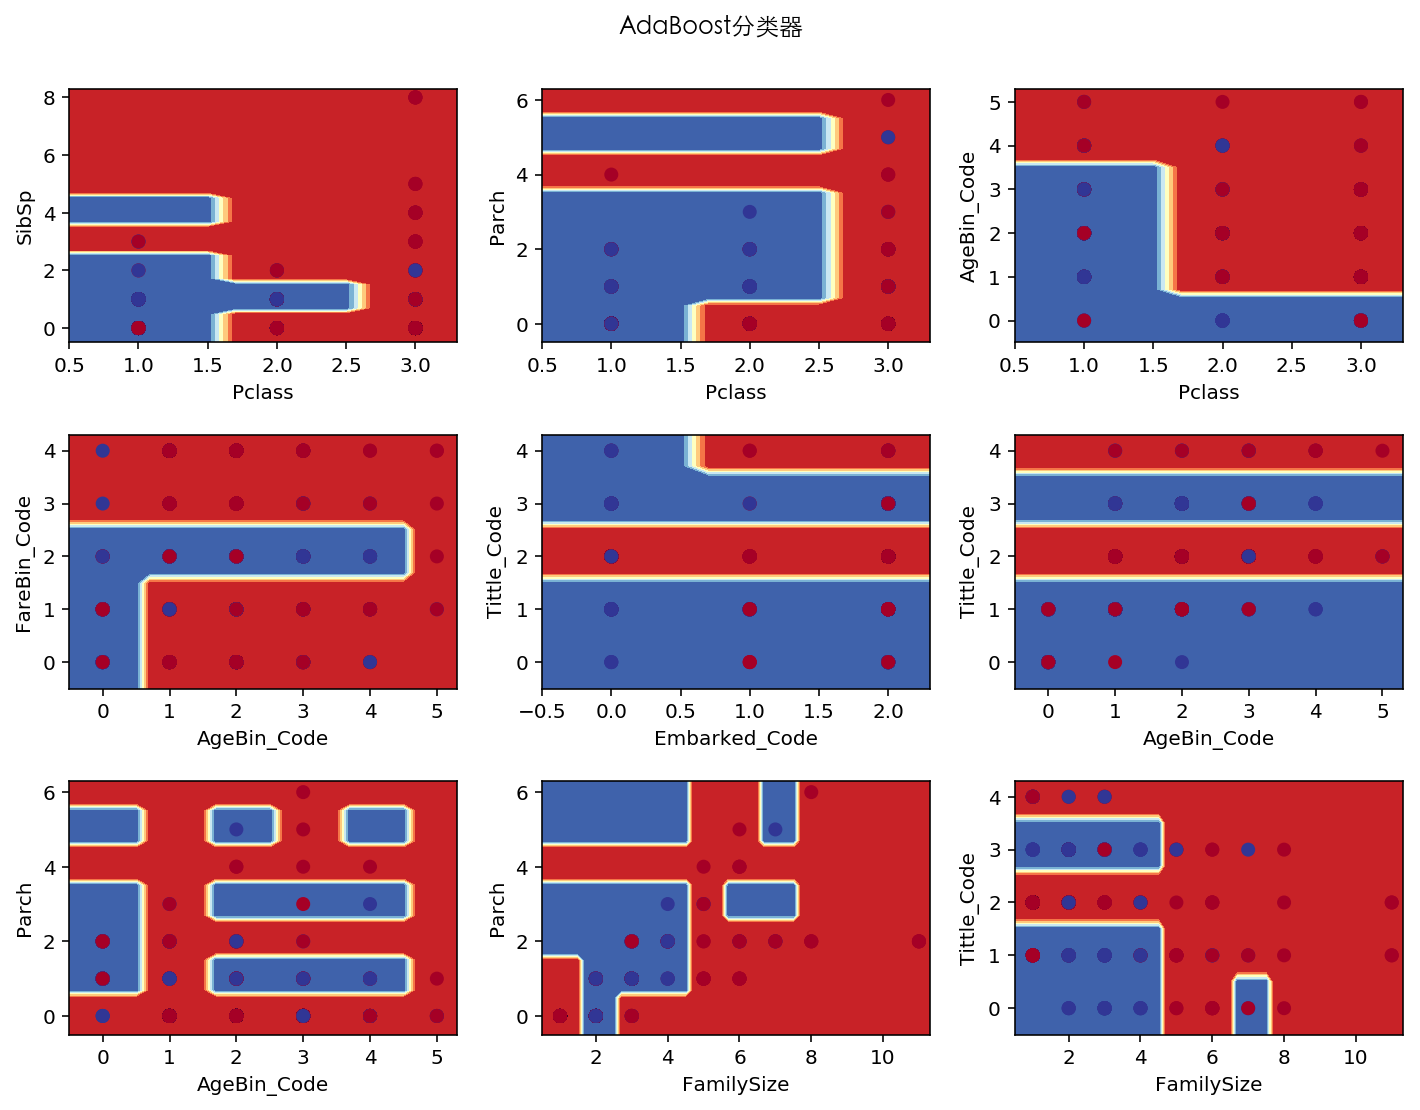

In [117]:
from sklearn import clone
## 用相同的参数构造一个新的估计器。
## Clone在估计器中完成模型的深层副本，而不实际复制附加数据。 它产生了一个具有相同参数的新估计器，该参数尚未适用于任何数据。
## 查看不同特征数据下的分类决策面的情况
pairs = [('Pclass','SibSp'),('Pclass','Parch'),('Pclass','AgeBin_Code'),
         ('AgeBin_Code','FareBin_Code'),('Embarked_Code','Tittle_Code'),
         ('AgeBin_Code','Tittle_Code'),('AgeBin_Code','Parch'),
         ('FamilySize','Parch'),('FamilySize','Tittle_Code')]
fig = plt.figure(figsize=(10,8))
for ii,pair in enumerate(pairs):
    X = traindata_x[list(pair)]
    Y = traindata_y
    clf = clone(abf)
    clf.fit(X,Y)
    scores = clf.score(X, Y)
    ## 生成新的网格数据用于预测
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                         np.arange(y_min, y_max, 0.2))
    ## 预测新数据
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.subplot(3,3,ii+1)
    ## 绘制分界面
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    ## 绘制原始数据
    plt.scatter(X.iloc[:, 0],X.iloc[:, 1],c=Y.iloc[:,0],cmap=plt.cm.RdYlBu)
    plt.xlabel(pair[0])
    plt.ylabel(pair[1])
    
plt.suptitle("AdaBoost分类器",FontProperties = fonts,va="center", ha="center")
## 调整图像
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
    